In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout, Input, Add, Dense, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score
import itertools

2025-04-23 14:44:35.804747: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745419476.000466      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745419476.059928      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Define paths and filenames
path = Path(r"/kaggle/input/utkface-new/UTKFace")
filenames = list(map(lambda x: x.name, path.glob('*.jpg')))

# Shuffle filenames
np.random.seed(10)
np.random.shuffle(filenames)

In [3]:
# Extract age and gender labels from filenames
age_labels, gender_labels, image_path = [], [], []

for filename in filenames:
    image_path.append(filename)
    temp = filename.split('_')
    age_labels.append(temp[0])
    gender_labels.append(temp[1])

In [4]:
# Create DataFrame
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_path, age_labels, gender_labels

# Convert data types
gender_dict = {0:"Male", 1:"Female"}
df = df.astype({'age': 'float32', 'gender': 'int32'})

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23708 entries, 0 to 23707
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   image   23708 non-null  object 
 1   age     23708 non-null  float32
 2   gender  23708 non-null  int32  
dtypes: float32(1), int32(1), object(1)
memory usage: 370.6+ KB


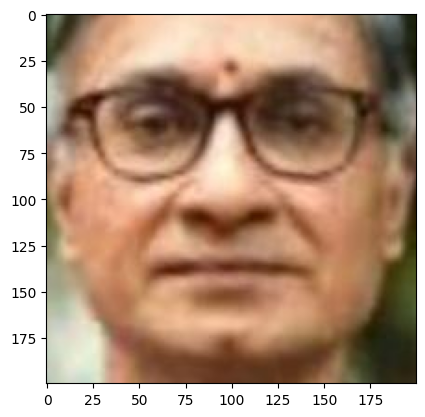

In [6]:
# Load and display an example image
img = Image.open(path / df.image[150])
plt.imshow(img)

/tmp/ipykernel_31/1084832650.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.age)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='age', ylabel='Density'>

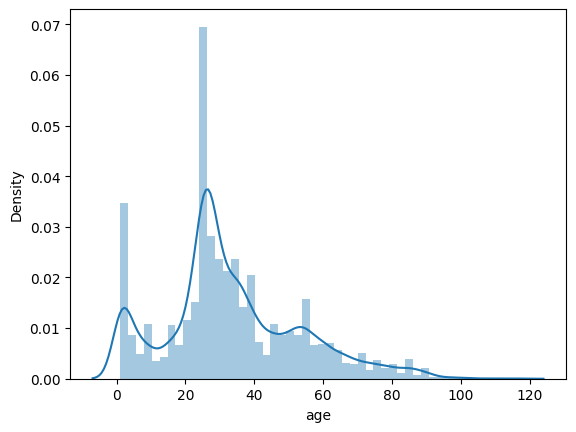

In [7]:
# Plot distributional graph for age
sns.distplot(df.age)

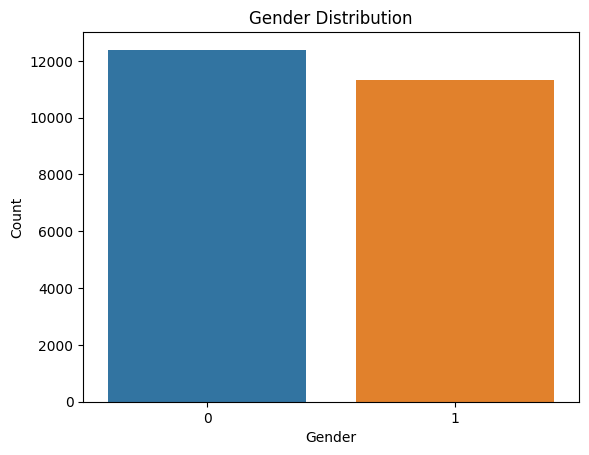

In [8]:

# Count plot for the 'gender' column
sns.countplot(x='gender', data=df)

# Add labels for better readability
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')

# Show the plot
plt.show()

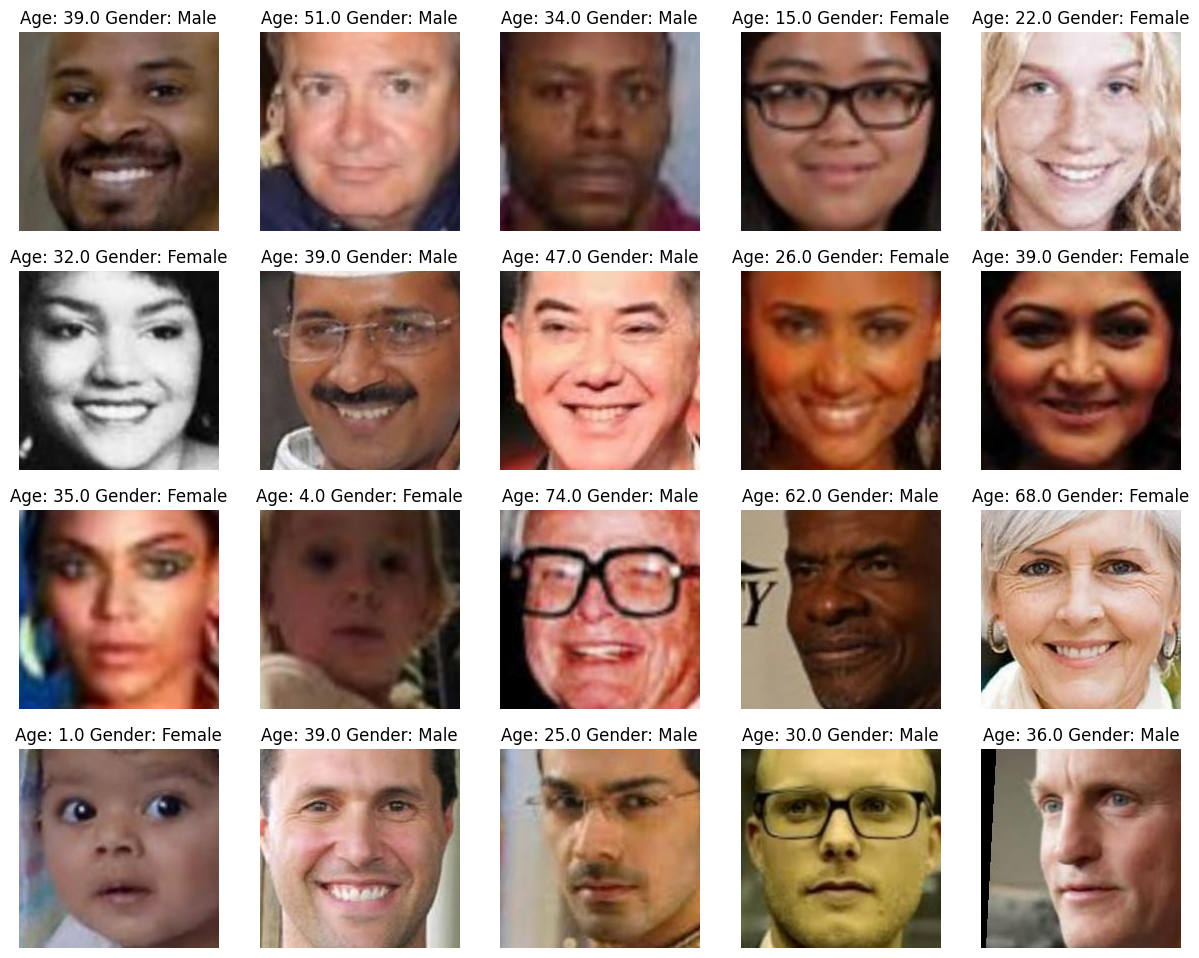

In [9]:
# Display some example images with age and gender labels
files = df.iloc[0:20]
plt.figure(figsize=(15, 15))
for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(path / file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

In [10]:
# Train-test split
train, test = train_test_split(df, test_size=0.20, random_state=42)

In [11]:
# Prepare training data
x_train = []
for file in train.image:
    img = load_img(path / file, color_mode='grayscale')
    img = img.resize((128, 128))
    img = np.array(img)
    x_train.append(img)

x_train = np.array(x_train) 
x_train = x_train.reshape(len(x_train), 128, 128, 1)
x_train = x_train / 255

# Prepare labels
y_gender = np.array(train.gender)
y_age = np.array(train.age)

In [39]:
input_shape = (128, 128, 1)
inputs = Input(shape=input_shape)
X = Conv2D(64, (3, 3), activation='relu')(inputs)
X = MaxPooling2D((2, 2))(X)
X = Conv2D(128, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2))(X)
X = Conv2D(256, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2))(X)
X = Flatten()(X)
X = Dense(512, activation='relu')(X)
X = Dropout(0.5)(X)

# Output layers
output_gender = Dense(1, activation='sigmoid', name='gender_output')(X)
output_age = Dense(1, activation='linear', name='age_output')(X)

In [40]:
# Compile the model
model = Model(inputs=inputs, outputs=[output_gender, output_age])
model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy',"r2_score"])

In [41]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [42]:
# Train the model
model_history = model.fit(x_train, [y_gender, y_age], batch_size=32, epochs=50, validation_split=0.1)

Epoch 1/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - age_output_loss: 15.4179 - age_output_r2_score: -0.0702 - gender_output_accuracy: 0.5804 - gender_output_loss: 0.8768 - loss: 16.2947 - val_age_output_loss: 10.5631 - val_age_output_r2_score: 0.5499 - val_gender_output_accuracy: 0.7997 - val_gender_output_loss: 0.4144 - val_loss: 11.0474
Epoch 2/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - age_output_loss: 10.4196 - age_output_r2_score: 0.4975 - gender_output_accuracy: 0.7984 - gender_output_loss: 0.4455 - loss: 10.8652 - val_age_output_loss: 10.0220 - val_age_output_r2_score: 0.5478 - val_gender_output_accuracy: 0.8482 - val_gender_output_loss: 0.3564 - val_loss: 10.4208
Epoch 3/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - age_output_loss: 9.2508 - age_output_r2_score: 0.5984 - gender_output_accuracy: 0.8191 - gender_output_loss: 0.3906 - loss: 9.6414 - val_age_output_loss: 8.3970 - val_age_output_r2_score: 0.6714 - val_gender_output_accuracy: 0.8513 - val_gender_output_los

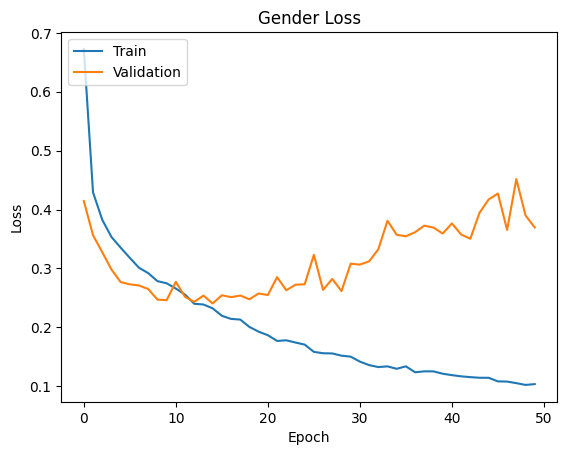

In [43]:
# Plot loss and accuracy for gender
plt.plot(model_history.history['gender_output_loss'])
plt.plot(model_history.history['val_gender_output_loss'])
plt.title('Gender Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

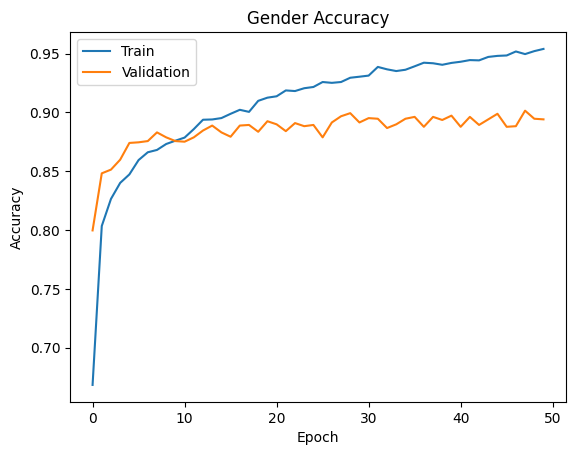

In [44]:
plt.plot(model_history.history['gender_output_accuracy'])
plt.plot(model_history.history['val_gender_output_accuracy'])
plt.title('Gender Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

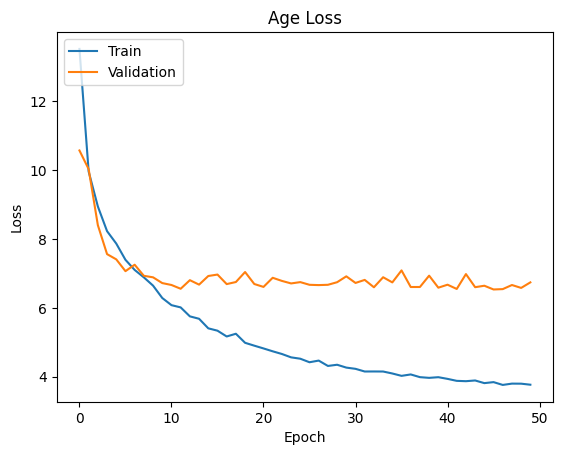

In [45]:
# Plot loss and accuracy for age
plt.plot(model_history.history['age_output_loss'])
plt.plot(model_history.history['val_age_output_loss'])
plt.title('Age Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

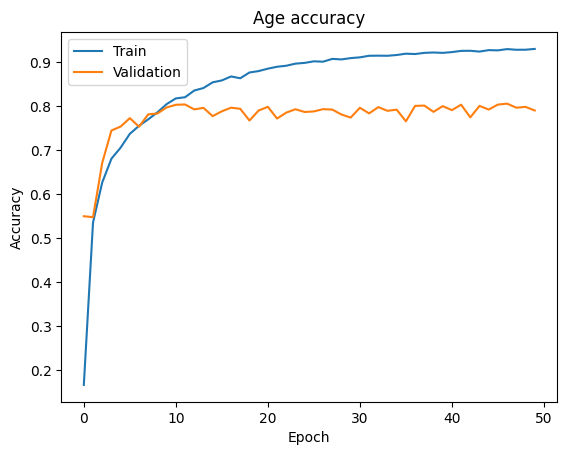

In [46]:
plt.plot(model_history.history['age_output_r2_score'])
plt.plot(model_history.history['val_age_output_r2_score'])
plt.title('Age accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [47]:
test.image.iloc[19]

'54_0_0_20170109010246118.jpg.chip.jpg'

Original Gender: Female Original Age: 26.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted Gender: Female Predicted Age: 26


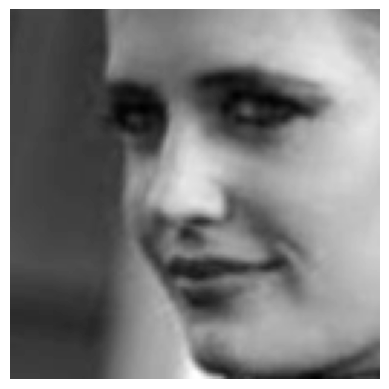

In [50]:
#random number for get image
image_index = 25
print("Original Gender:", gender_dict[test.gender.iloc[image_index]], "Original Age:", test.age.iloc[image_index])
# predict from model


image_path = os.path.join("/kaggle/input/utkface-new/UTKFace",test.image.iloc[image_index])  # Assuming this is a file path
img = Image.open(image_path).convert('L')  # Convert to grayscale
img = img.resize((128, 128))  # Resize to match model input
img_num = np.array(img)  # Convert to NumPy array
img = img_num.reshape(1, 128, 128, 1)  # Add batch dimension
img = img / 255.0  # Normalize
pred = model.predict(img)
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(img_num.reshape(128, 128), cmap='gray');

In [51]:
def predict_age_gender(image_path):
    try:
        img = load_img(image_path, color_mode='grayscale')
        img = img.resize((128, 128))
        img = np.array(img)
        img = img.reshape(1, 128, 128, 1)
        img = img / 255.0

        prediction = model.predict(img,verbose=0)
        predicted_gender = (prediction[0] > 0.5).astype("int32")[0][0]
        predicted_age = int(prediction[1][0])

        return predicted_gender, predicted_age
    except Exception as e:
        print(f"Error processing image: {e}")
        return None, None

# Predict age and gender for all test data
predicted_genders = []
predicted_ages = []
path = "/kaggle/input/utkface-new/UTKFace"

for i in range(len(test)):
    image_path = os.path.join(path,test.image.iloc[i])
    predicted_gender, predicted_age = predict_age_gender(image_path)

    if predicted_gender is not None:
      predicted_genders.append(predicted_gender)
      predicted_ages.append(predicted_age)
    else:
      predicted_genders.append(None)
      predicted_ages.append(None)

/tmp/ipykernel_31/172554942.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_age = int(prediction[1][0])


In [54]:

# Calculate precision, recall, and F1-score
precision = precision_score(test.gender, predicted_genders)
recall = recall_score(test.gender, predicted_genders)
f1 = f1_score(test.gender,predicted_genders)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")


# Calculate age error rate (Mean Absolute Error)
age_error_rate = np.mean(np.abs(test.age - predicted_ages)) 
print(f"Age error rate (MAE): {age_error_rate}")


Precision: 0.880709534368071
Recall: 0.8870031263957123
F1-score: 0.8838451268357811
Age error rate (MAE): 6.730071699704766


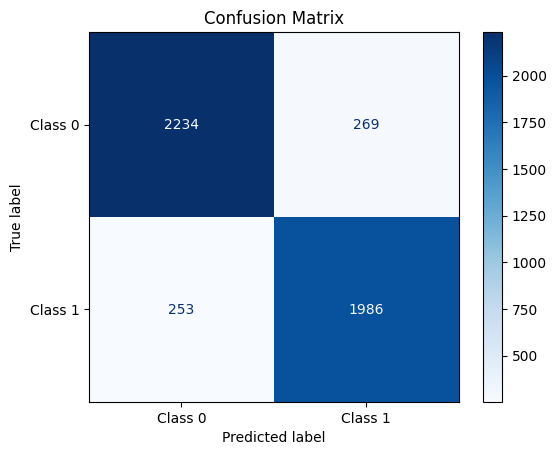

In [55]:
# Compute confusion matrix
cm = confusion_matrix(test.gender, predicted_genders)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])  # Change class names as needed
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [56]:
model.save("model1.h5")

In [57]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 128, 128, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 126, 126, 64)   │            640 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 63, 63, 64)     │              0 │ conv2d_6[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 61, 61, 128)    │         73,856 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 30, 30, 128)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 28, 28, 256)    │        295,168 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 14, 14, 256)    │              0 │ conv2d_8[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 50176)          │              0 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 512)            │     25,690,624 │ flatten_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 512)            │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gender_output (Dense)     │ (None, 1)              │            513 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ age_output (Dense)        │ (None, 1)              │            513 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 78,183,944 (298.25 MB)

 Trainable params: 26,061,314 (99.42 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 52,122,630 (198.83 MB)